<a href="https://colab.research.google.com/github/somnath3112/Rocky_Road_DRL/blob/main/DeepRL_basics_with_RockyRoad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics

## Py libraries

In [1]:
import numpy as np
import random
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.linalg import solve_continuous_are, solve_discrete_are

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
!pip install tensorflow

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Input
from keras import activations, backend
# import pydot
# import graphviz
import matplotlib.image as mpimg # <-- viz network image file

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(6,6))
ax2 = plt.subplot(1,1,1)

#
from matplotlib import animation
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  en_colab_mode = True
except:
  en_colab_mode = False

In [ ]:
import sys
print ('Running in colab:', 'google.colab' in sys.modules)
if 'google.colab' in sys.modules:
  en_colab_mode = True
else:
  en_colab_mode = False

# Theory of Deep RL

### RL algorithms broad picture
Source: https://www.semanticscholar.org/paper/Reinforcement-Learning-Algorithms%3A-An-Overview-and-AlMahamid-Grolinger/594e2663ba038f02651f3de853f1064084f72839

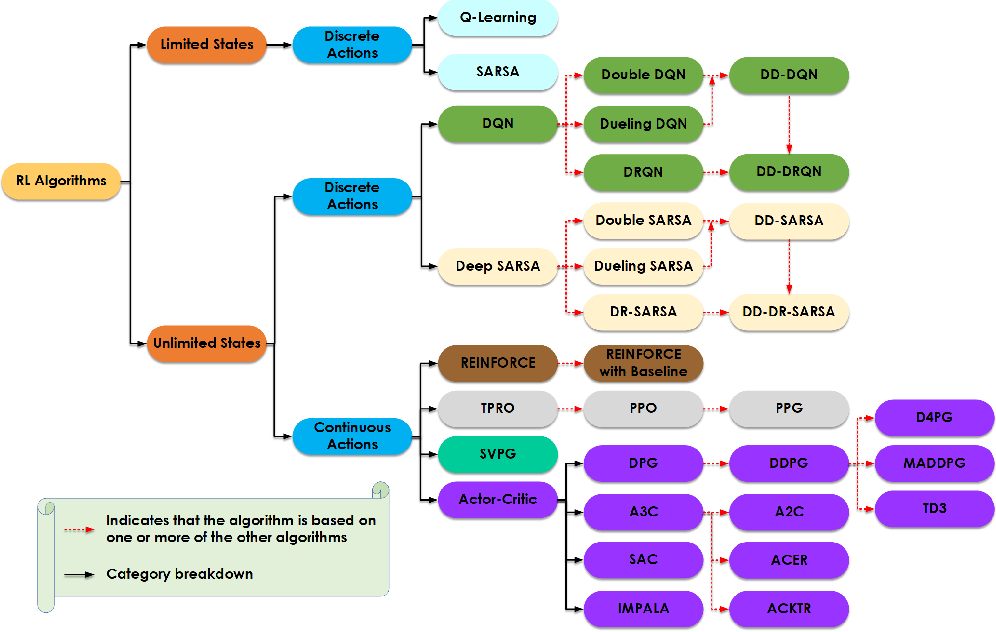

#### DDPG - Actor-Critc for continuous control (deepmind)

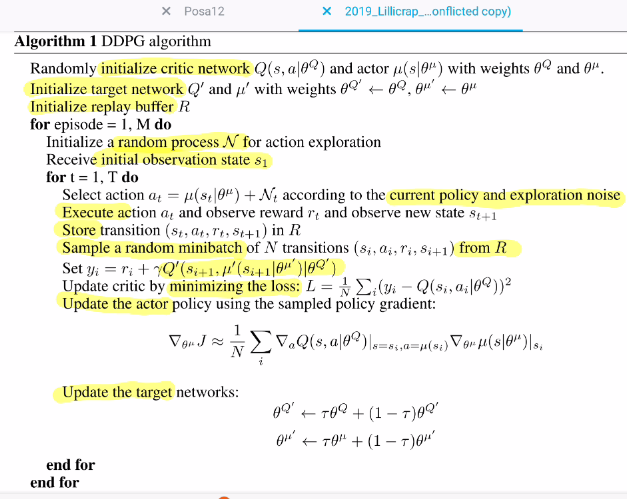

More resource on DPG (slides): https://www.pair.toronto.edu/csc2621-w20/assets/slides/lec3_ddpg.pdf

# DRL main - Actor and Critic

In [ ]:
#@title NN class

class nn_model_create:
  def __init__(self,input_shape,hidden_layers_size,output_size,en_colab_mode=True,mdl_name='actor_network'):
    self.name = mdl_name
    x = Input(shape=input_shape)
    layer1 = Dense(hidden_layers_size,activation='relu')
    layer2 = Dense(output_size,activation='linear')
    y = layer2(layer1(x))
    self.model = Model(x,y)
    self.we_are_on_colab = en_colab_mode

  def layer_summary(self):
    self.model.summary()
    try:
      keras.utils.plot_model(
          self.model,
          to_file=self.name+"_viz.png",
          show_shapes=True,
          show_dtype=False,
          show_layer_names=True,
          rankdir='TB',
          expand_nested=False,
          dpi=96,
          layer_range=None,
          show_layer_activations=True,
          show_trainable=False
        )
      img = mpimg.imread("/content/"+self.name+"_viz.png")
      plt.imshow(img)
    except:
      print("\x1b[31mNo `network stucture image` generated! Try running in `google colab`! \x1b[0m")

  def loss_fcn(self,lbls,pred):
    return tf.reduce_sum( (lbls-pred)**2 )

  def load_weights(self,name=None):
    if name is None:
      name = self.name
    success = False
    try:
      if self.we_are_on_colab:
        self.model.load_weights('/content/drive/MyDrive/Colab Notebooks/DeepLearning/{}.h5'.format(name))
      else:
        self.model.load_weights(r'C:\Users\Som\Documents\DL\{}.h5'.format(name))
      success = True
    except:
      print("\x1b[31mNo `h5` file exists in the specified directory! OR The model is changed! \x1b[0m")
    return success

  def save_weights(self,name=None):
    if name is None:
      name = self.name
    success = False
    try:
      if self.we_are_on_colab:
        self.model.save_weights('/content/drive/MyDrive/Colab Notebooks/DeepLearning/{}.h5'.format(name))
      else:
        self.model.save_weights(r'C:\Users\Som\Documents\DL\{}.h5'.format(name))
      success = True
    except:
      print("\x1b[31mProbably path not found to save! \x1b[0m")
    return success

  def compile_default(self):
    self.model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer="adam",
        metrics=["accuracy"],
    )

  def start_training(self,train_batch_x,train_batch_y,batch_size,set_epochs,test_batch_x=None,test_batch_y=None,verbose=2,simple=False):
    if test_batch_x is None:
      if simple:
        self.model.fit(
            train_batch_x, train_batch_y, batch_size=batch_size, epochs=set_epochs, verbose=verbose
        )
      test_batch_x, test_batch_y = dict(), dict()
      if type(train_batch_x) is dict:
        tmp = train_batch_x[list(train_batch_x.keys())[0]]
      else:
        tmp = train_batch_x
      sz_split_for_test = int(np.floor(0.3*np.array(tmp.shape[0])))
      if type(train_batch_x) is dict:
        for key in train_batch_x.keys():
          test_batch_x[key] = train_batch_x[key][:sz_split_for_test]
          train_batch_x[key] = train_batch_x[key][sz_split_for_test:]
        for key in train_batch_y.keys():
          test_batch_y[key] = train_batch_y[key][:sz_split_for_test]
          train_batch_y[key] = train_batch_y[key][sz_split_for_test:]
      else:
        test_batch_x, test_batch_y = train_batch_x[:sz_split_for_test], train_batch_y[:sz_split_for_test]
        train_batch_x, train_batch_y = train_batch_x[sz_split_for_test:], train_batch_y[sz_split_for_test:]

    # print(test_batch_x,test_batch_y)
    # print(train_batch_x,train_batch_y)
    self.model.fit(
        train_batch_x, train_batch_y, validation_data=(test_batch_x, test_batch_y), batch_size=batch_size, epochs=set_epochs, verbose=verbose
    )

  def custom_training(self,fts_train,lbls_train,fts_val,lbls_val,epochs=500,lr=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    best_accuracy=0.0
    for ep in range(epochs+1):
      with tf.GradientTape(persistent=True) as tape:
        loss = self.loss_fcn(lbls_train,self.model(fts_train))

      variables = tape.watched_variables()
      grads = tape.gradient(loss,variables)
      optimizer.apply_gradients(zip(grads,variables))

      loss_train = self.loss_fcn(fts_train,lbls_train)
      loss_val = self.loss_fcn(fts_val,lbls_val)
      print('Epoch:',ep,' | Training loss:',loss_train.numpy(),' | Val loss: ',loss_val.numpy())

  def check(self,batch_x):
    # batch_x = np.expand_dims(init_condition,axis=0)
    return self.model.evaluate(batch_x)

  def predict(self,feature):
    batch_x = np.expand_dims(feature,axis=0)
    return self.model.predict(
      batch_x,
      batch_size = None,
      verbose = 0,
      steps = None,
      callbacks = None,
      max_queue_size = 10,
      workers = 1,
      use_multiprocessing = False
    )[0,:]


In [ ]:
test = {'1':10,'2':20}
test[list(test.keys())[0]]

In [ ]:
#@title The DQN Critic class

class dqn_critic_nn(nn_model_create):
  def __init__(self,state_shape,control_shape,hidden_layers_size,output_size,en_colab_mode=True,mdl_name='new'):
    self.name = mdl_name+'_critic_network'
    state = Input(shape=state_shape,name='state')
    action = Input(shape=control_shape,name='action')
    layer1a = Dense(hidden_layers_size,activation='relu')
    layer1b = Dense(hidden_layers_size,activation='relu')
    layer2 = Dense(2*hidden_layers_size,activation='relu')
    # layer3 = Dense(hidden_layers_size,activation='linear')
    layer4 = Dense(hidden_layers_size,activation='relu')
    # layer5 = Dense(int(np.ceil(hidden_layers_size/2)),activation='linear')
    # layer6 = Dense(int(np.ceil(hidden_layers_size/2)),activation='relu')
    layer7 = Dense(int(np.ceil(hidden_layers_size/2)),activation='linear')
    layer8 = Dense(output_size,activation='linear',name='q_value')
    # q_val = layer8(layer7(layer6(layer5(layer4(layer3(layer2(layer1a(state) + layer1b(action))))))))
    q_val = layer8(layer7(layer4(layer2(layer1a(state) + layer1b(action)))))#layer6(layer5(layer3()))
    self.model = Model([state,action],q_val)
    self.we_are_on_colab = en_colab_mode

  def predict(self,state,action):
    batch_x = [np.expand_dims(state,axis=0), np.expand_dims(action,axis=0)]
    return self.model.predict(
      batch_x,
      batch_size = None,
      verbose = 0,
      steps = None,
      callbacks = None,
      max_queue_size = 10,
      workers = 1,
      use_multiprocessing = False
    )[0,:][0]

dqn_test = dqn_critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=18,output_size=1,en_colab_mode=en_colab_mode)
dqn_test.layer_summary()
print('DQN critic test: ',dqn_test.predict([-9],[0]))
# # # print(dqn_test.model.get_weights())
test_lbls = np.array([[2.0],[1.0],[2.0],[3.0]]) # <-- reward batch
test_fts = [ [[2.0],[1.0],[2.0],[3.0]], [[2],[1],[2],[0]] ] # <-- state and action batch
# # test_pred = dqn_test.model.predict(test_fts)
# # print(test_lbls, test_pred)
# # print(tf.reduce_mean( tf.reduce_sum(test_lbls*test_pred, axis=1) ))
# # print(dqn_test.loss_fcn(test_lbls,test_pred))
# # test_critic = critic_nn(state_shape=(3,),control_shape=(2,),hidden_layers_size=3,output_size=1)
# # with tf.GradientTape(persistent=True) as tape:
# #   print(test_critic.model([test_fts,dqn_test.model.predict(test_fts)]))
# # print(dqn_test.custom_training(test_fts,test_critic,set_epochs=0,lr=0.001))
dqn_test.compile_default()
fts = {'state':np.array(test_fts[0]), 'action':np.array(test_fts[1])}
lbls = {'q_value': test_lbls}
dqn_test.start_training(fts,lbls,batch_size=test_lbls.shape[0],set_epochs=1)

In [ ]:
#@title The REINFORCE Actor class

class reinforce_actor_nn(nn_model_create):
  def __init__(self,input_shape,hidden_layers_size,output_size,en_colab_mode=True,mdl_name='new'):
    self.name = mdl_name+'_actor_network'
    x = Input(shape=input_shape,name='state')
    layer1 = Dense(hidden_layers_size,activation='relu')
    layer2 = Dense(hidden_layers_size,activation='relu')
    layer3 = Dense(hidden_layers_size,activation='linear')
    layer4 = Dense(output_size,activation='sigmoid')
    layer5 = tf.keras.layers.Softmax(name='policy')
    y = layer5(layer4(layer3(layer2(layer1(x)))))
    self.model = Model(x,y)
    self.we_are_on_colab = en_colab_mode
    self.output_size = output_size

  # def loss_fcn(self,lbls,pred):
  #   # print('Pred and Lbls: ',pred,lbls)
  #   return -tf.reduce_mean( tf.reduce_sum(lbls*pred,axis=1) ) # <-- maximize the reward: mean( grad_Q(s,a)*Pi(s) ) :: lbls=grad_Q & fts=s

  # def compile_default(self):
  #   self.model.compile(
  #       loss=self.loss_fcn,
  #       optimizer="adam",
  #       metrics=["accuracy"],
  #   )

  @tf.function
  def custom_loss_fcn(self,fts,oh_action_ft):
    # print(fts, lbls)
    # print(self.model(fts))
    # print('check ops = ', self.model(fts)*lbls)
    # print(self.model(fts))
    # print(oh_action_ft)
    # print(tf.linalg.matmul(self.model(fts),oh_action_ft))
    return tf.math.log( tf.matmul(self.model(fts),oh_action_ft) ) # <-- maximize the reward: mean( grad_Q(s,a)*Pi(s) ) :: lbls=grad_Q & fts=s

  # @tf.function
  def custom_training(self,fts_train,lbls_train,set_epochs=500,lr=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    best_accuracy=0.0
    fts_action_one_hot = tf.one_hot(fts_train[1].T,self.output_size)
    for ep in range(set_epochs+1):
      # print('actions = ',fts_train[1].T)
      # print('one hot action = ',fts_action_one_hot[0])
      for state_ft,oh_action_ft,lbl in zip(fts_train[0],fts_action_one_hot[0],lbls_train):
        with tf.GradientTape(persistent=True) as tape:
          log_pi = self.custom_loss_fcn(np.array([state_ft]),np.array([oh_action_ft]).T)

        variables = tape.watched_variables()
        grad_log_pi = tape.gradient(log_pi,variables)
        # print('log_pi=',log_pi)
        # print('vars=',variables)
        # print('grad_log_pi = ', grad_log_pi)
        # for items in grad_log_pi:
        #   print('grad_log_pi items = ', items)
        # print('The state = \n{}, \nthe one hot action = \n{}, \nand label = \n{}\n'\
        #       .format(state_ft,oh_action_ft,lbl))
        # print([lbl[0]*val for val in grad_log_pi])
        grads = [lbl[0]*val for val in grad_log_pi]
        # print('grads = ',grads)
        optimizer.apply_gradients(zip(grads,variables))

      # loss_train = self.custom_loss_fcn(fts_train[0],fts_action_one_hot[0])
      # loss_val = self.custom_loss_fcn(fts_val,critic_network)
      print('Epoch: {} of {} | Total reward: {}'.format(ep, set_epochs, lbls_train[-1][0])) #,' | Training loss:',loss_train.numpy()) #,' | Val loss: ',loss_val.numpy())

  def predict(self,feature):
    batch_x = np.array([np.expand_dims(feature,axis=0),np.expand_dims(feature,axis=0)])
    return self.model.predict(
      batch_x,
      batch_size = None,
      verbose = 0,
      steps = None,
      callbacks = None,
      max_queue_size = 10,
      workers = 1,
      use_multiprocessing = False
    )[0,:]


test_ann = reinforce_actor_nn(input_shape=(1,),hidden_layers_size=3,output_size=3) # <-- output_size=nactions
print('REINFORCE actor test: ',test_ann.predict([-9]))
test_ann.layer_summary()
# # # print(test_ann.model.get_weights())
test_lbls = np.array([[2.0],[1.0],[2.0],[3.0]]) # <-- reward batch
test_fts = np.array([ [[2.0],[1.0],[2.0],[3.0]], [[2],[1],[2],[0]] ]) # <-- state and action batch
# # test_pred = test_ann.model.predict(test_fts)
# # print(test_lbls, test_pred)
# # print(tf.reduce_mean( tf.reduce_sum(test_lbls*test_pred, axis=1) ))
# # print(test_ann.loss_fcn(test_lbls,test_pred))
# # test_critic = critic_nn(state_shape=(3,),control_shape=(2,),hidden_layers_size=3,output_size=1)
# # with tf.GradientTape(persistent=True) as tape:
# #   print(test_critic.model([test_fts,test_ann.model.predict(test_fts)]))
# # print(test_ann.custom_training(test_fts,test_critic,set_epochs=0,lr=0.001))
test_ann.compile_default()
test_ann.custom_training(test_fts,test_lbls,set_epochs=0)

In [ ]:
#@title The REINFORCE-2 Actor class for deterministic action

class reinforce2_actor_nn(nn_model_create):
  def __init__(self,input_shape,hidden_layers_size,output_size,en_colab_mode=True,mdl_name='new'):
    self.name = mdl_name+'_actor_network'
    x = Input(shape=input_shape,name='state')
    layer1 = Dense(hidden_layers_size,activation='relu')
    layer2 = Dense(hidden_layers_size/2,activation='relu')
    layer3 = Dense(hidden_layers_size/2,activation='linear')
    layer4 = Dense(output_size,activation='sigmoid',name='policy')
    # layer5 = tf.keras.layers.Softmax(name='policy')
    # y = layer5(layer4(layer3(layer2(layer1(x)))))
    y = layer4(layer3(layer2(layer1(x))))
    self.model = Model(x,y)
    self.we_are_on_colab = en_colab_mode
    self.output_size = output_size

  # def loss_fcn(self,lbls,pred):
  #   # print('Pred and Lbls: ',pred,lbls)
  #   return -tf.reduce_mean( tf.reduce_sum(lbls*pred,axis=1) ) # <-- maximize the reward: mean( grad_Q(s,a)*Pi(s) ) :: lbls=grad_Q & fts=s

  # def compile_default(self):
  #   self.model.compile(
  #       loss=self.loss_fcn,
  #       optimizer="adam",
  #       metrics=["accuracy"],
  #   )

  # def custom_loss_fcn(self,fts,oh_action_ft):
  #   # print(fts, lbls)
  #   # print(self.model(fts))
  #   # print('check ops = ', self.model(fts)*lbls)
  #   # print(self.model(fts))
  #   # print(oh_action_ft)
  #   # print(tf.linalg.matmul(self.model(fts),oh_action_ft))
  #   return tf.math.log( tf.matmul(self.model(fts),oh_action_ft) ) # <-- maximize the reward: mean( grad_Q(s,a)*Pi(s) ) :: lbls=grad_Q & fts=s

  # def custom_training(self,fts_train,lbls_train,set_epochs=500,lr=0.001): # ISSUE: Non-trainable setting is useless if manually updating weights, I think
  #   optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  #   best_accuracy=0.0
  #   fts_action_one_hot = tf.one_hot(fts_train[1].T,self.output_size)
  #   for ep in range(set_epochs+1):
  #     # print('actions = ',fts_train[1].T)
  #     # print('one hot action = ',fts_action_one_hot[0])
  #     for state_ft,oh_action_ft,lbl in zip(fts_train[0],fts_action_one_hot[0],lbls_train):
  #       with tf.GradientTape(persistent=True) as tape:
  #         log_pi = self.custom_loss_fcn(np.array([state_ft]),np.array([oh_action_ft]).T)

  #       variables = tape.watched_variables()
  #       grad_log_pi = tape.gradient(log_pi,variables)
  #       # print('log_pi=',log_pi)
  #       # print('vars=',variables)
  #       # print('grad_log_pi = ',grad_log_pi)
  #       # for items in grad_log_pi:
  #       #   print(items)
  #       # print(state_ft,action_ft,lbl)
  #       grads = lbl*grad_log_pi
  #       # print('grads = ',grads)
  #       optimizer.apply_gradients(zip(grads,variables))

  #     # loss_train = self.custom_loss_fcn(fts_train[0],fts_action_one_hot[0])
  #     # loss_val = self.custom_loss_fcn(fts_val,critic_network)
  #     print('Epoch: {} of {} | Total reward: {}'.format(ep, set_epochs, lbls_train[-1][0])) #,' | Training loss:',loss_train.numpy()) #,' | Val loss: ',loss_val.numpy())

  # def predict(self,feature):
  #   batch_x = np.array([np.expand_dims(feature,axis=0),np.expand_dims(feature,axis=0)])
  #   return self.model.predict(
  #     batch_x,
  #     batch_size = None,
  #     verbose = 0,
  #     steps = None,
  #     callbacks = None,
  #     max_queue_size = 10,
  #     workers = 1,
  #     use_multiprocessing = False
  #   )[0,:]


test_ann = reinforce2_actor_nn(input_shape=(1,),hidden_layers_size=3,output_size=1) # <-- output_size=nactions
print('REINFORCE actor test: ',test_ann.predict([-9]))
test_ann.layer_summary()
# # # print(test_ann.model.get_weights())
test_lbls = np.array([[2.0],[1.0],[2.0],[3.0]]) # <-- reward batch
test_fts = np.array( [[2.0],[1.0],[2.0],[3.0]] ) # <-- state and action batch
# # test_pred = test_ann.model.predict(test_fts)
# # print(test_lbls, test_pred)
# # print(tf.reduce_mean( tf.reduce_sum(test_lbls*test_pred, axis=1) ))
# # print(test_ann.loss_fcn(test_lbls,test_pred))
# # test_critic = critic_nn(state_shape=(3,),control_shape=(2,),hidden_layers_size=3,output_size=1)
# # with tf.GradientTape(persistent=True) as tape:
# #   print(test_critic.model([test_fts,test_ann.model.predict(test_fts)]))
# # print(test_ann.custom_training(test_fts,test_critic,set_epochs=0,lr=0.001))
test_ann.compile_default()
test_ann.start_training(test_fts,test_lbls,batch_size=4,set_epochs=0)

In [ ]:
#@title The Critic class

class critic_nn(nn_model_create):
  def __init__(self,state_shape,control_shape,hidden_layers_size,output_size,en_colab_mode=True,mdl_name='new'):
    self.name = mdl_name+'_critic_network'
    state = Input(shape=state_shape,name='state')
    action = Input(shape=control_shape,name='action')
    layer1a = Dense(hidden_layers_size,activation='relu')
    layer1b = Dense(hidden_layers_size,activation='relu')
    layer2 = Dense(2*hidden_layers_size,activation='relu')
    # layer3 = Dense(hidden_layers_size,activation='linear')
    layer4 = Dense(hidden_layers_size,activation='relu')
    # layer5 = Dense(int(np.ceil(hidden_layers_size/2)),activation='linear')
    # layer6 = Dense(int(np.ceil(hidden_layers_size/2)),activation='relu')
    layer7 = Dense(int(np.ceil(hidden_layers_size/2)),activation='linear')
    layer8 = Dense(output_size,activation='linear',name='q_value')
    # q_val = layer8(layer7(layer6(layer5(layer4(layer3(layer2(layer1a(state) + layer1b(action))))))))
    q_val = layer8(layer7(layer4(layer2(layer1a(state) + layer1b(action)))))#layer6(layer5(layer3()))
    self.model = Model([state,action],q_val)
    self.we_are_on_colab = en_colab_mode

  # def __init__(self,state_shape,control_shape,hidden_layers_size,output_size,en_colab_mode=True,mdl_name='new'):
  #   self.name = mdl_name+'_critic_network'
  #   state = Input(shape=state_shape,name='state')
  #   action = Input(shape=control_shape,name='action')
  #   layer1a = Dense(hidden_layers_size,activation='relu')
  #   layer1b = Dense(hidden_layers_size,activation='relu')
  #   layer2a = Dense(hidden_layers_size,activation='linear')
  #   layer2b = Dense(hidden_layers_size,activation='linear')
  #   layer3 = Dense(hidden_layers_size,activation='linear')
  #   layer4 = Dense(output_size,activation='linear',name='q_value')
  #   q_val = layer4(layer3(layer2a(layer1a(state) + layer2b(layer1b(action)))))
  #   self.model = Model([state,action],q_val)
  #   self.we_are_on_colab = en_colab_mode

  # def predict(self,feature):
  #   batch_x = [np.expand_dims(inputs,axis=0) for inputs in feature]
  #   return self.model.predict(
  #     batch_x,
  #     batch_size = None,
  #     verbose = 0,
  #     steps = None,
  #     callbacks = None,
  #     max_queue_size = 10,
  #     workers = 1,
  #     use_multiprocessing = False
  #   )[0,:][0]

  def predict(self,state,action):
    batch_x = [np.expand_dims(state,axis=0), np.expand_dims(action,axis=0)]
    return self.model.predict(
      batch_x,
      batch_size = None,
      verbose = 0,
      steps = None,
      callbacks = None,
      max_queue_size = 10,
      workers = 1,
      use_multiprocessing = False
    )[0,:][0]

critic_nn(state_shape=(3,),control_shape=(2,),hidden_layers_size=3,output_size=1).layer_summary()

In [ ]:
#@title The Actor class

class actor_nn(nn_model_create):
  def __init__(self,input_shape,hidden_layers_size,output_size,en_colab_mode=True,mdl_name='new',action_range=[0.,1.]):
    self.action_range = np.array(action_range,dtype=np.float32)
    self.diff_action_range = np.array([self.action_range[0]+(self.action_range[1]-self.action_range[0])/2, \
                                       (self.action_range[1]-self.action_range[0])/2])
    # cstm_actvn = lambda x: backend.constant(action_range[0])+backend.constant(action_range[1]-action_range[0])*backend.relu(x,max_value=1.0)
    self.name = mdl_name+'_actor_network'
    x = Input(shape=input_shape,name='state')
    layer1 = Dense(hidden_layers_size,activation='relu')
    layer2 = Dense(hidden_layers_size/2,activation='relu')
    layer3 = Dense(hidden_layers_size/2,activation='linear')
    # layer4 = Dense(output_size,activation='linear',name='policy')
    layer4 = Dense(output_size,activation=self.cstm_actvn,name='policy')
    y = layer4(layer3(layer2(layer1(x)))) #tf.math.sigmoid()
    self.model = Model(x,y)
    self.model.set_weights([1e-1*w for w in self.model.get_weights()])
    self.we_are_on_colab = en_colab_mode

  @tf.function
  def cstm_actvn(self,x):
    # return backend.constant(self.action_range[0])+backend.constant(self.action_range[1]-self.action_range[0])*backend.relu(x,max_value=1.0)
    # return backend.constant(self.action_range[0])+backend.constant(self.action_range[1]-self.action_range[0])*backend.sigmoid(x)
    # return backend.constant(self.diff_action_range[0])+backend.relu(x,max_value=self.diff_action_range[1],threshold=-self.diff_action_range[1])
    # return backend.constant(self.action_range[0])+tf.math.mod(x,2*self.diff_action_range[1]+1)
    return backend.constant(self.diff_action_range[0])+backend.constant(self.diff_action_range[1])*backend.tanh(x)

  def loss_fcn(self,lbls,pred):
    # print('Pred and Lbls: ',pred,lbls)
    return -tf.reduce_mean( tf.reduce_sum(lbls*pred,axis=1) ) # <-- maximize the reward: mean( grad_Q(s,a)*Pi(s) ) :: lbls=grad_Q & fts=s

  def compile_default(self):
    self.model.compile(
        loss=self.loss_fcn,
        optimizer="adam",
        metrics=["accuracy"],
    )

  # def custom_loss_fcn(self,fts,critic_network):
  #   # print(fts, self.model(fts))
  #   # print(critic_network.model([fts,self.model(fts)]))
  #   return -tf.reduce_mean( critic_network.model([fts,self.model(fts)]) ) # <-- maximize the reward: mean( grad_Q(s,a)*Pi(s) ) :: lbls=grad_Q & fts=s

  # def custom_training(self,fts_train,critic_network,epochs=500,lr=0.001): # ISSUE: Non-trainable setting is useless if manually updating weights, I think
  #   optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  #   best_accuracy=0.0
  #   for layer in critic_network.model.layers:
  #     layer.trainable = False
  #   # critic_network.layer_summary()
  #   for ep in range(epochs+1):
  #     with tf.GradientTape(persistent=True) as tape:
  #       loss = self.custom_loss_fcn(fts_train,critic_network)

  #     variables = tape.watched_variables()
  #     # print(variables)
  #     grads = tape.gradient(loss,variables)
  #     optimizer.apply_gradients(zip(grads,variables))

  #     loss_train = self.custom_loss_fcn(fts_train,critic_network)
  #     # loss_val = self.custom_loss_fcn(fts_val,critic_network)
  #     print('Epoch:',ep,' | Training loss:',loss_train.numpy()) #,' | Val loss: ',loss_val.numpy())

  #   # Trainiable again
  #   for layer in critic_network.model.layers:
  #     layer.trainable = True
  #   # critic_network.layer_summary()

  def concat_loss_fcn(self,lbls,pred):
    # print(lbls,pred)
    return -tf.reduce_mean( pred ) # <-- maximize the reward: Q(s,Pi(s))

  def concat_model_training(self,feature,critic_network,batch_size,set_epochs,test_batch_x=None,test_batch_y=None):
    for layer in critic_network.model.layers:
      layer.trainable = False
    cc_model = Model(self.model.input,\
                     critic_network.model([self.model.input,self.model.output]))
    # cc_model = Model(self.model.input,\
    #                  critic_network.model([self.model.input,\
    #                                        tf.math.minimum(tf.math.maximum(self.action_range[0],\
    #                                                                        self.model.output),\
    #                                                        self.action_range[1])]))
    # cc_model.summary()
    cc_model.compile(
        loss=self.concat_loss_fcn,
        optimizer="adam",
        metrics=["accuracy"],)
    # if test_batch_x is None:
    cc_model.fit(
        feature, feature, batch_size=batch_size, epochs=set_epochs
    )
    for layer in critic_network.model.layers:
      layer.trainable = True
    # cc_model.summary()

  def predict(self,feature):
    batch_x = np.expand_dims(feature,axis=0)
    return self.model.predict(
      batch_x,
      batch_size = None,
      verbose = 0,
      steps = None,
      callbacks = None,
      max_queue_size = 10,
      workers = 1,
      use_multiprocessing = False
    )[0,:]
    # return tf.math.minimum(tf.math.maximum(self.action_range[0],self.model.predict(
    #   batch_x,
    #   batch_size = None,
    #   verbose = 0,
    #   steps = None,
    #   callbacks = None,
    #   max_queue_size = 10,
    #   workers = 1,
    #   use_multiprocessing = False
    # )[0,:]),self.action_range[1])

test_ann = actor_nn(input_shape=(3,),hidden_layers_size=3,output_size=2)
test_ann.layer_summary()
# # print(test_ann.model.get_weights())
test_lbls = np.array([[1,2],[2,1],[1,2],[3,2]])
test_fts = np.array([[1,2,3],[3,2,1],[3,4,3],[1,2,3]])
test_pred = test_ann.model.predict(test_fts)
print('Label and prediction = \n',test_lbls, test_pred)
# print(tf.reduce_mean( tf.reduce_sum(test_lbls*test_pred, axis=1) ))
# print(test_ann.loss_fcn(test_lbls,test_pred))
test_critic = critic_nn(state_shape=(3,),control_shape=(2,),hidden_layers_size=3,output_size=1)
# with tf.GradientTape(persistent=True) as tape:
#   print(test_critic.model([test_fts,test_ann.model.predict(test_fts)]))
# print(test_ann.custom_training(test_fts,test_critic,epochs=0,lr=0.001))
test_ann.concat_model_training(test_fts,test_critic,batch_size=2,set_epochs=1)

# Implementation of DRL

## RockyRoad system

In [ ]:
#@title Import RockyRoad

if en_colab_mode:
    %run /content/drive/MyDrive/Current\ Important/ACTIVE/3-Colab\ Work/VVY\ LQRscc/RockyRoad_env_and_RL_basics.ipynb
else:
    %run RockyRoad_env_and_RL_basics.ipynb

rr = rocky_road()
print('Number of states = {}, Number of action = {}'.format(rr.nstates,rr.nactions))
rr.render()
print('X-axis are states (each column) and there are three parallel actions leading to next state (the next column)')

print('\n \n Start game ...')
for action in range(3):
  ns,rwd,_,_ = rr.step(action)
  print('Take acion = ',action)
  print('At state = ',ns)
  print('Reward for the action = ',rwd)
  rr.render()

## Learning a q-value function from q-value table

In [ ]:
#@title The q-value table and its performance

print(q_value_best.T)
plt.imshow(q_value_best[:,::-1].T)
plt.show()

policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title The chosen network

hidden_layers_size_critic = 20
rf_test_train_critic = dqn_critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,\
                                   output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='q_value_learn')
rf_test_train_critic.load_weights()
rf_test_train_critic.layer_summary()

In [ ]:
#@title Data for learning the q-value table

print('The environment is called "rr".')

fts_ip1, fts_ip2, lbls_op1 = [], [], []
# fts = []

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_best[state,action]))
    fts_ip1.append(state)
    fts_ip2.append(action)
    lbls_op1.append( q_value_best[state,action] )

fts = {'state':np.array(fts_ip1), 'action':np.array(fts_ip2)}
lbls = {'q_value': np.expand_dims(np.array(lbls_op1),axis=1)}

print('The features[state] are \n{}\n and the features[action] are \n{}\n'.format(fts['state'].T,fts['action'].T))
print('The q-values are {}'.format(lbls['q_value'].T))
print('The shape of state-features is {} and action-features is {}.'.format(fts['state'].shape,fts['action'].shape))
print('The shape of labels is {}'.format(lbls['q_value'].shape))

In [ ]:
#@title Learning the q-value table

rf_test_train_critic.compile_default()
for i in range(10):
  rf_test_train_critic.start_training(fts,lbls,batch_size=int(lbls['q_value'].shape[0]/4),set_epochs=100)
  rf_test_train_critic.save_weights()

In [ ]:
#@title Test the q-value learned network

q_value_learned = np.array([[0 for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_learned = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_learned[state,action]))
    q_value_learned[state,action] = rf_test_train_critic.predict(state,action)

  policy_learned[state] = np.argmax(q_value_learned[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print(q_value_learned.T)
plt.imshow(q_value_learned[:,::-1].T)
plt.show()

policy_learned = [np.argmax(q_value_learned[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_learned,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print(q_value_best.T)
plt.imshow(q_value_best[:,::-1].T)
plt.show()

policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title Test on the environment

def get_best_action(self,state):
  cumulative_rewards = np.array([rf_test_train_critic.predict(state,action) for action in range(self.env.nactions)])
  # print('cumulative rewards for all actions = {}'.format(cumulative_rewards))
  u = np.argmax(cumulative_rewards)
  # print('control action = {}'.format(u))
  # u = int(np.max([0]+[np.min([np.ceil(rf_test_train_critic.predict(state)[0])]+[2])]))
  return u, cumulative_rewards[u]

## DQN

In [ ]:
#@title DQN algorithm

class dqn():
  def __init__(self,train_critic,target_critic,env):
    # data generation parameters
    self.no_episodes = 250
    self.horizon = env.nstates
    # action generation parameters
    self.epsilon = 1
    per_epsilon = 0.6
    self.epsilon_multiplier = 0.1**(1/(per_epsilon*self.no_episodes)) # (per_epsilon)% of no_episodes epsilon reaches 10% value
    # storage and sampling parameters
    self.buffer = [] # <-- initialize replay buffer
    self.buffer_size = 0
    self.buffer_max_size = 100
    self.min_buffer_sz_4_training = 50
    self.number_of_terminal_observations = 5
    # training parameters
    self.train_critic_epochs = 250
    self.batch_size = min([32,int((self.min_buffer_sz_4_training+self.number_of_terminal_observations)/2)])
    self.target_update_factor = np.array([0.09])
    self.target_update_ep = 5
    # DRL parameters
    self.gamma = 1.0
    # env
    self.env = env
    # main
    self.train_critic = train_critic # <-- initialize network
    self.target_critic = target_critic # <-- initialize network
    # compile networks
    self.train_critic.compile_default()
    self.target_critic.compile_default()
    # load weights
    self.load_weights()

  def load_weights(self,name=None):
    if name is not None:
        train_name = 'train'+name
        target_name = 'target'+name
    else:
        train_name = None
        target_name = None
    self.train_critic.load_weights(train_name)
    return self.target_critic.load_weights(target_name)

  def save_weights(self,name=None):
    if name is not None:
        train_name = 'train'+name
        target_name = 'target'+name
    else:
        train_name = None
        target_name = None
    self.train_critic.save_weights(train_name)
    return self.target_critic.save_weights(target_name)

  def run(self,en_train=True):
    # run the episodes
    for ep in range(self.no_episodes):
      self.epsilon = self.epsilon*self.epsilon_multiplier # <-- exploration factor
      current_state = self.env.reset() # <-- initial state
      for t in range(self.horizon):
        # generate episode from env
        action = self.epsilon_greedy(current_state)
        observation, reward, done, info = self.env.step(action)
        # print(current_state, action, reward, observation)
        # store in replay buffer
        self.buffer.append( (current_state,action,reward,observation) )
        if self.buffer_size>=self.buffer_max_size:
          self.buffer.pop(0)
        else:
          self.buffer_size += 1
        # set new starting state
        current_state = observation
        # if self.buffer_size==18:
        #   print(self.buffer)
        #   return
        #
        if done:
          break

      # train
      if self.buffer_size>=self.min_buffer_sz_4_training:
        self.train_the_networks(self.sample_from_buffer())
      # # update the target networks
      if ep%self.target_update_ep==0:
        self.update_network()
      # save weights
      self.save_weights()

  # DRL codes ##################################################################
  def get_best_action(self,state):
    cumulative_rewards = np.array([self.target_critic.predict(state,np.array([action])) for action in range(self.env.nactions)])
    # print('cumulative rewards for all actions = {}'.format(cumulative_rewards))
    u = np.array([np.argmax(cumulative_rewards)])
    # print('control action = {}'.format(u))
    # u = int(np.max([0]+[np.min([np.round(self.target_critic.predict(state)[0])]+[2])]))
    return u, cumulative_rewards[u][0]

  def epsilon_greedy(self,state):
    if random.uniform(0,1)<self.epsilon:
      u = np.array([int(np.round(random.uniform(0,2)))])
      # print('Control random = ',u)
    else:
      u, _ = self.get_best_action(state)
      # print('Control predict = ',u)
    return u

  def sample_from_buffer(self,sample_buffer_size=None):
    if sample_buffer_size is None:
      sample_buffer_size=self.min_buffer_sz_4_training
    # possible_start_points = max(1,self.buffer_size - self.min_buffer_sz_4_training)
    # sampling_start_index = random.sample([val for val in range(possible_start_points)],1)[0]
    # sampling_end_index = sampling_start_index + self.min_buffer_sz_4_training
    # # print('start index = {} & end index = {}'.format(sampling_start_index,sampling_end_index))
    # sampled_buffer = self.buffer[sampling_start_index:sampling_end_index]
    random_sample_indxs = random.sample(np.arange(self.buffer_size).tolist(),sample_buffer_size)
    sampled_buffer = [self.buffer[indx] for indx in random_sample_indxs]
    return sampled_buffer

  def train_the_networks(self,sample_data,simple=False):
    # Critic
    # > label and features
    fts_ip1, fts_ip2, lbls_op1 = [], [], []
    # fts = []
    for val in sample_data:
      # print(sample_data[0][0],val[0])
      state, action, reward, next_state = val[0], val[1], val[2], val[3]
      fts_ip1.append(state)
      fts_ip2.append(action)
      # fts.append([state,action])
      _, best_qvalue = self.get_best_action(next_state)
      lbls_op1.append( reward + self.gamma*best_qvalue ) # reward + gamma*max_over_action( Q_target(next_state, action) )
      # print(reward + self.gamma*best_qvalue)
      # print(self.train_critic.predict([state,action]))
    lbls_op1, fts_ip1, fts_ip2 = self.add_terminal_labels(lbls_op1,fts_ip1,fts_ip2)
    fts = {'state':np.array(fts_ip1,dtype=np.float64), 'action':np.array(fts_ip2,dtype=np.float64)}
    lbls = {'q_value': np.array(lbls_op1,dtype=np.float64)} # lbls = {'q_value': np.expand_dims(np.array(lbls_op1),axis=1)}
    # print('The state-features are = \n{}\n and the action-features are = \n{}\n'.format(fts['state'].T,fts['action'].T))
    # print('The labels are = \n{}\n'.format(lbls['q_value'].T))
    # print('The state-feature shape is {} and the action-feature space is {}.'.format(fts['state'].shape,fts['action'].shape))
    # print('The label shape is {}'.format(lbls['q_value'].shape))
    # > training
    self.train_critic.start_training(fts,lbls,batch_size=self.batch_size,set_epochs=self.train_critic_epochs,simple=simple)

  def add_terminal_labels(self,labels,feature_state,feature_action):
    for i in range(self.number_of_terminal_observations):
      state = self.env.goal_state
      action = self.env.sample_action_space(1)[0]
      labels.append( 0.0 )
      feature_state.append(state)
      feature_action.append(action)
    return labels, feature_state, feature_action

  def update_network(self):
    self.target_critic.model.set_weights(self.target_update_factor*np.array(self.train_critic.model.get_weights(),dtype=object) \
                                        + (1-self.target_update_factor)*np.array(self.target_critic.model.get_weights(),dtype=object))

#Build critic, target and critic network
hidden_layers_size_critic = 10
rf_test_train_critic = dqn_critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,\
                                   output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='dqn_test_train')
rf_test_target_critic = dqn_critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,\
                                   output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='dqn_test_target')
print('dqn train critic test: ',rf_test_train_critic.predict([-9],[0]))
print('dqn target critic test: ',rf_test_target_critic.predict([-9],[0]))

dqn_rr_test = dqn(rf_test_train_critic,rf_test_target_critic,rocky_road())
dqn_rr_test.no_episodes = 2
print('Buffer size at start: ',dqn_rr_test.buffer_size)
dqn_rr_test.epsilon = 0.5
print('Setting balanced exploration and exploitation (epsilon = {})'.format(dqn_rr_test.epsilon))
dqn_rr_test.train_critic_epochs = 1
print('Total epochs = {}'.format(dqn_rr_test.train_critic_epochs))
dqn_rr_test.run()
dqn_rr_test.env.render()
print('Buffer size after run: ',dqn_rr_test.buffer_size)
print('Training will be intiated if replay_buffer size is greater than ',dqn_rr_test.min_buffer_sz_4_training)
print('Sampled buffer size: ',len(dqn_rr_test.sample_from_buffer(dqn_rr_test.buffer_size)))
# # more
dqn_rr_test.train_critic_epochs = 1
dqn_rr_test.train_the_networks(dqn_rr_test.sample_from_buffer(dqn_rr_test.buffer_size))
# dqn_rr_test.update_network()

### Step-by-step

In [ ]:
#@title Step 1: Q-target is zero, Q-learn will be ...

# Setting up the DNNs
hidden_layers_size_critic = 25
rf_test_train_critic = dqn_critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,\
                                   output_size=1,en_colab_mode=en_colab_mode,mdl_name='dqn_test_train')
rf_test_target_critic = dqn_critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,\
                                   output_size=1,en_colab_mode=en_colab_mode,mdl_name='dqn_test_target')
print('dqn train critic test: ',rf_test_train_critic.predict([-9],[0]))
print('dqn target critic test: ',rf_test_target_critic.predict([-9],[0]))

# The DQN object
dqn_rr_test = dqn(rf_test_train_critic,rf_test_target_critic,rocky_road())

# Set the buffer with all possible samples
print('Current size of replay buffer = {}'.format(dqn_rr_test.buffer_size))
for state_val in range(rr.nstates-1):
  for action_val in range(rr.nactions):
    state = np.array([state_val])
    action = np.array([action_val])
    next_state = state + 1
    rwd = rr.reward_state[next_state,action][0]
    # print('State = {}, Action = {}, Reward = {}, Next state = {}'.format(state,action,rwd,next_state))
    dqn_rr_test.buffer.append( (state,action,rwd,next_state) )
    dqn_rr_test.buffer_size += 1

# for action_val in range(rr.nactions): # <-- Terminal dataset is already in the code
#   dqn_rr_test.buffer.append( (np.array([rr.nstates-1]),np.array([action_val]),0.,np.array([rr.nstates-1])) )

# Train with all of buffer
if not dqn_rr_test.load_weights('dqn_rr_test_step1'):
    dqn_rr_test.train_critic_epochs = 10000
    dqn_rr_test.train_the_networks(dqn_rr_test.buffer, simple=True)
    dqn_rr_test.save_weights('dqn_rr_test_step1')

# dqn_rr_test.update_network()

# Display
q_value_dqn_train = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
q_value_dqn_target = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_dqn = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_dqn[state,action]))
    q_value_dqn_train[state,action] = dqn_rr_test.train_critic.predict([state],[action])
    q_value_dqn_target[state,action] = dqn_rr_test.target_critic.predict([state],[action])

  policy_dqn[state] = np.argmax(q_value_dqn_target[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print('Q-target:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_target.T]))
plt.imshow(q_value_dqn_target[:,::-1].T)
plt.show()
print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
# print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
# print(q_value_best.T)
# plt.imshow(q_value_best[:,::-1].T)
# plt.show()

# policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
# plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
# plt.legend()
# rr.reset()
# rr.render()

In [ ]:
#@title Step 2: Q-target is Q-train of 1st iter, Q-train will be ...

# Transfer learnt weights to target
dqn_rr_test.target_update_factor = 1.
dqn_rr_test.update_network()

# Train with all of buffer
if not dqn_rr_test.load_weights('dqn_rr_test_step2'):
    dqn_rr_test.train_critic_epochs = 5000
    dqn_rr_test.train_the_networks(dqn_rr_test.buffer, simple=True)
    dqn_rr_test.save_weights('dqn_rr_test_step2')

# dqn_rr_test.update_network()

# Display
q_value_dqn_train = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
q_value_dqn_target = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_dqn = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_dqn[state,action]))
    q_value_dqn_train[state,action] = dqn_rr_test.train_critic.predict([state],[action])
    q_value_dqn_target[state,action] = dqn_rr_test.target_critic.predict([state],[action])

  policy_dqn[state] = np.argmax(q_value_dqn_target[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print('Q-target:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_target.T]))
plt.imshow(q_value_dqn_target[:,::-1].T)
plt.show()
print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
# print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
# print(q_value_best.T)
# plt.imshow(q_value_best[:,::-1].T)
# plt.show()

# policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
# plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
# plt.legend()
# rr.reset()
# rr.render()

In [ ]:
#@title Step 3: Q-target is Q-train of 2nd iter, Q-train will be ...

# Transfer learnt weights to target
dqn_rr_test.target_update_factor = 1.
dqn_rr_test.update_network()

# Train with all of buffer
if not dqn_rr_test.load_weights('dqn_rr_test_step3'):
    dqn_rr_test.train_critic_epochs = 2000
    dqn_rr_test.train_the_networks(dqn_rr_test.buffer, simple=True)
    dqn_rr_test.save_weights('dqn_rr_test_step3')

# dqn_rr_test.update_network()

# Display
q_value_dqn_train = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
q_value_dqn_target = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_dqn = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_dqn[state,action]))
    q_value_dqn_train[state,action] = dqn_rr_test.train_critic.predict([state],[action])
    q_value_dqn_target[state,action] = dqn_rr_test.target_critic.predict([state],[action])

  policy_dqn[state] = np.argmax(q_value_dqn_target[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print('Q-target:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_target.T]))
plt.imshow(q_value_dqn_target[:,::-1].T)
plt.show()
print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
# print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
# print(q_value_best.T)
# plt.imshow(q_value_best[:,::-1].T)
# plt.show()

# policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
# plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
# plt.legend()
# rr.reset()
# rr.render()

### Formal run

In [ ]:
#@title Build critic network for DQN

hidden_layers_size_critic = 20
rf_train_critic = dqn_critic_nn(state_shape=rr.state_shape,control_shape=rr.action_shape,hidden_layers_size=hidden_layers_size_critic,\
                                   output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='dqn_train')
rf_train_critic.layer_summary()
print('DQN critic test: ',rf_train_critic.predict([-9],[0]))
hidden_layers_size_critic = 20
rf_target_critic = dqn_critic_nn(state_shape=rr.state_shape,control_shape=rr.action_shape,hidden_layers_size=hidden_layers_size_critic,\
                                   output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='dqn_target')
rf_target_critic.layer_summary()
print('DQN critic test: ',rf_target_critic.predict([-9],[0]))

# network
dqn_rr = dqn(rf_train_critic,rf_target_critic,rocky_road())

In [ ]:
#@title Check devices

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
#@title Start training

with tf.device('/device:GPU:0'):
  for _ in range(10):
    dqn_rr.run()

In [ ]:
#@title Test the critic network on sampled data

# sample_data = dqn_rr.sample_from_buffer()
# # print(sample_data)
# print('start q_value = ',dqn_rr.critic.predict([dqn_rr.env.start+[0.0],[0.0,0.0]]))
# q_vals = []
# for val in sample_data:
#   state, action, reward, next_state = val[0], val[1], val[2], val[3]
#   q_vals.append(dqn_rr.critic.predict([state,action]))

# plt.plot(q_vals)
# plt.show()
# # print('actor weights:',dqn_rr.actor.model.get_weights())

In [ ]:
#@title for testing the Delta_q

# for state in range(rr.nstates-1):
#     best_q_ns = np.max([dqn_rr.target_critic.predict([state+1],[action]) for action in range(rr.nactions)])
#     for action in range(rr.nactions):
#         print('The \delta q_value(state={},action={},next_state={}) is {}.'.\
#               format(state,action,state+1,\
#                      best_q_ns-dqn_rr.train_critic.predict([state],[action]) ))

In [ ]:
#@title Test on the environment with learned-policy

env_test = rocky_road()

state = env_test.reset()
print('Initial state = {}'.format(state))
reward_traj = []
env_test.render()
for i in range(env_test.nstates-1):
  action, _ = dqn_rr.get_best_action(state)
  state, reward, _, _ = env_test.step(action)
  reward_traj.append(reward)
  env_test.render()

# plt.title('State trajectory')
# env_test.render()
plt.plot(reward_traj)
plt.title('Reward trajectory')
plt.show()

In [ ]:
#@title Test the q-value learned network

q_value_dqn = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_dqn = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_dqn[state,action]))
    q_value_dqn[state,action] = dqn_rr.target_critic.predict([state],[action])

  policy_dqn[state] = np.argmax(q_value_dqn[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print(np.array([[int(val) for val in rows] for rows in q_value_dqn.T]))
plt.imshow(q_value_dqn[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print(q_value_best.T)
plt.imshow(q_value_best[:,::-1].T)
plt.show()

policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

## Learning a REINFORCE-policy function from best q-value action table (to-do)

In [ ]:
#@title The best_policy_matrix from q-value table

policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

print('best policy matrix = ')
best_policy_matrix = np.zeros((rr.nactions,rr.nstates))
for i,val in enumerate(policy_best):
  best_policy_matrix[val,i] = 1
print(best_policy_matrix)

In [ ]:
#@title The chosen network for REINFORRCE actor

hidden_layers_size_actor = 20
rf_test_train_actor = reinforce_actor_nn(input_shape=(1,),hidden_layers_size=hidden_layers_size_actor,\
                                   output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='reinforce_policy_learn')
rf_test_train_actor.load_weights()
rf_test_train_actor.layer_summary()

In [ ]:
#@title Feature and label data for learning the q-value table

print('The environment is called "rr".')

fts_ip, lbls_op = [], []
# fts = []

for state in range(rr.nstates):
  # print('The policy for state={} is {}'.format(state,action,q_value_best[state,action]))
  fts_ip.append(state)
  lbls_op.append( best_policy_matrix[:,state] )

fts = {'state':np.expand_dims(np.array(fts_ip),axis=1)}
lbls = {'policy': np.array(lbls_op)}

print('The features[state] are \n{}\n'.format(fts['state'].T))
print('The policy values are {}'.format(lbls['policy'].T))
print('The shape of state-features is {}.'.format(fts['state'].shape))
print('The shape of labels is {}'.format(lbls['policy'].shape))

In [ ]:
#@title Learning the q-value table

rf_test_train_actor.compile_default()
for i in range(10):
  rf_test_train_actor.start_training(fts,lbls,batch_size=int(lbls['policy'].shape[0]/4),set_epochs=10000)
  rf_test_train_actor.save_weights()

In [ ]:
#@title Test the q-value learned network

policy_learned = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_learned[state,action]))
    policy = rf_test_train_actor.predict(state)

  policy_learned[state] = np.random.choice(rr.nactions,size=1,p=policy)

print('\n<<<<< The learned policy: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')

# policy_learned = [np.argmax(q_value_learned[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_learned[:-1],'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
print('\n<<<<< The BEST policy: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
policy_best = [np.random.choice(rr.nactions,size=1,p=best_policy_matrix[:,s]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title Test on the environment

def get_best_action(self,state):
  cumulative_rewards = np.array([rf_test_train_critic.predict(state,action) for action in range(self.env.nactions)])
  # print('cumulative rewards for all actions = {}'.format(cumulative_rewards))
  u = np.argmax(cumulative_rewards)
  # print('control action = {}'.format(u))
  # u = int(np.max([0]+[np.min([np.round(rf_test_train_critic.predict(state)[0])]+[2])]))
  return u, cumulative_rewards[u]

## REINFORCE (to-do)

In [ ]:
#@title REINFORCE

class reinforce():
  def __init__(self,actor,env):
    # data generation parameters
    self.no_episodes = 1000
    self.horizon = env.nstates
    # action generation parameters
    self.epsilon = 1
    self.epsilon_multiplier = 0.91
    # storage and sampling parameters
    self.buffer_size = 0
    self.buffer_max_size = 100
    self.min_buffer_sz_4_training = 50
    self.number_of_terminal_observations = 10
    # training parameters
    self.actor_epochs = 250
    self.batch_size = min([32,int((self.min_buffer_sz_4_training+self.number_of_terminal_observations)/2)])
    # DRL parameters
    self.gamma = 1.0
    # env
    self.env = env
    # main
    self.actor = actor # <-- initialize network
    self.buffer = [] # <-- initialize replay buffer
    # compile networks
    self.actor.compile_default()
    # load weights
    self.actor.load_weights()

  def run(self,en_train=True):
    # run the episodes
    for ep in range(self.no_episodes):
      self.epsilon = self.epsilon*self.epsilon_multiplier # <-- exploration factor
      current_state = self.env.reset() # <-- initial state
      self.buffer = []
      self.buffer_size = 0
      for t in range(self.horizon):
        # generate episode from env
        action = self.epsilon_greedy(current_state)
        observation, reward, done, info = self.env.step(action)
        # print(reward)
        # store in replay buffer
        self.buffer.append( (current_state,action,reward,observation) )
        if self.buffer_size>=self.buffer_max_size:
          self.buffer.pop(0)
        else:
          self.buffer_size += 1
        # set new starting state
        current_state = observation
        # if self.buffer_size==18:
        #   print(self.buffer)
        #   return
        #
        if done:
          break

      # train
      self.train_the_networks(self.buffer)
      # # update the target networks
      # self.update_network()
      # save weights
      self.actor.save_weights()

  # DRL codes ##################################################################
  def get_best_action(self,state):
    action_probs = np.array(self.actor.predict([state]))
    # print('action probs = {}'.format(action_probs))
    u = np.random.choice(self.env.nactions, 1, p=action_probs)[0]
    # print('control action = {}'.format(u))
    # u = int(np.max([0]+[np.min([np.round(self.actor.predict(state)[0])]+[2])]))
    return u

  def epsilon_greedy(self,state):
    if random.uniform(0,1)<self.epsilon:
      u = int(np.round(random.uniform(0,2)))
      # print('Control random = ',u)
    else:
      u = self.get_best_action(state)
      # print('Control predict = ',u)
    return u

  def sample_from_buffer(self,sample_buffer_size=None):
    if sample_buffer_size is None:
      sample_buffer_size=self.min_buffer_sz_4_training
    # possible_start_points = max(1,self.buffer_size - self.min_buffer_sz_4_training)
    # sampling_start_index = random.sample([val for val in range(possible_start_points)],1)[0]
    # sampling_end_index = sampling_start_index + self.min_buffer_sz_4_training
    # # print('start index = {} & end index = {}'.format(sampling_start_index,sampling_end_index))
    # sampled_buffer = self.buffer[sampling_start_index:sampling_end_index]
    random_sample_indxs = random.sample(np.arange(self.buffer_size).tolist(),sample_buffer_size)
    sampled_buffer = [self.buffer[indx] for indx in random_sample_indxs]
    return sampled_buffer

  def train_the_networks(self,sample_data):
    # > label and features
    fts_st, fts_ac, lbls = [], [], []
    total_reward = 0.0
    # print(sample_data)
    for val in sample_data[::-1]:
      # print(sample_data[-1][0],val[0])
      state, action, reward, next_state = val[0], val[1], val[2], val[3]
      total_reward += reward
      fts_st.append( state )
      fts_ac.append( action )
      lbls.append(total_reward)
    fts = [np.expand_dims(np.array(fts_st),axis=1),np.expand_dims(np.array(fts_ac),axis=1)]
    lbls = np.expand_dims(np.array(lbls),axis=1)
    # print(np.array(fts[0].T),np.array(fts[1].T),np.array(lbls.T))
    # print(fts.shape,lbls.shape)
    # > training
    # self.actor.start_training(fts,lbls,batch_size=self.batch_size,set_epochs=self.actor_epochs)
    self.actor.custom_training(fts,lbls,set_epochs=self.actor_epochs)

  # def add_terminal_labels(self,labels,feature_state,feature_action):
  #   for i in range(self.number_of_terminal_observations):
  #     state = self.env.goal + [random.uniform(-np.pi,np.pi)]
  #     action = [0.0,0.0]
  #     labels.append( 0.0 )
  #     feature_state.append(state)
  #     feature_action.append(action)
  #   return labels, feature_state, feature_action

#Build critic, target and actor network
hidden_layers_size_actor = 10
rf_test_actor = reinforce_actor_nn(input_shape=(1,),hidden_layers_size=hidden_layers_size_actor,\
                                   output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='reinforce_test')
print('REINFORCE actor test: ',rf_test_actor.predict([-9]))

reinforce_rr_test = reinforce(rf_test_actor,rocky_road())
reinforce_rr_test.no_episodes = 3
print('Buffer size at start: ',reinforce_rr_test.buffer_size)
reinforce_rr_test.epsilon = 0.5
print('Setting balanced exploration and exploitation (epsilon = {})'.format(reinforce_rr_test.epsilon))
reinforce_rr_test.actor_epochs = 1
print('Total epochs = {}'.format(reinforce_rr_test.actor_epochs))
reinforce_rr_test.run()
reinforce_rr_test.env.render()
print('Buffer size after run: ',reinforce_rr_test.buffer_size)
print('Sampled buffer size: ',len(reinforce_rr_test.sample_from_buffer(reinforce_rr_test.buffer_size)))
# # more
# reinforce_rr_test.actor_epochs = 2
# reinforce_rr_test.critic_epochs = 2
# reinforce_rr_test.train_the_networks(reinforce_rr_test.sample_from_buffer(reinforce_rr_test.buffer_size))
# reinforce_rr_test.update_network()

In [ ]:
#@title Build actor network for REINFORCE
hidden_layers_size_actor = 60
rf_actor = reinforce_actor_nn(input_shape=(1,),hidden_layers_size=hidden_layers_size_actor,output_size=rocky_road().nactions\
                              ,en_colab_mode=en_colab_mode,mdl_name='REINFORCE_rocky_road')
rf_actor.layer_summary()
print('REINFORCE actor test: ',rf_actor.predict([-9]))

reinforce_rr = reinforce(rf_actor,rocky_road())

In [ ]:
#@title Check devices

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
#@title Start training

with tf.device('/device:GPU:0'):
  reinforce_rr.run()

In [ ]:
#@title Test the critic network on sampled data

sample_data = reinforce_rr.sample_from_buffer()
# print(sample_data)
print('start q_value = ',reinforce_rr.critic.predict([reinforce_rr.env.start+[0.0],[0.0,0.0]]))
q_vals = []
for val in sample_data:
  state, action, reward, next_state = val[0], val[1], val[2], val[3]
  q_vals.append(reinforce_rr.critic.predict([state,action]))

plt.plot(q_vals)
plt.show()
# print('actor weights:',reinforce_rr.actor.model.get_weights())

In [ ]:
#@title Test on the environment with actor-policy

env_test = rocky_road()

state = env_test.reset()
print('Initial state = {}'.format(state))
reward_traj = []
env_test.render()
for i in range(env_test.nstates-1):
  action = reinforce_rr.get_best_action(state)
  state, reward, _, _ = env_test.step(action)
  reward_traj.append(reward)
  env_test.render()

# plt.title('State trajectory')
# env_test.render()
plt.plot(reward_traj)
plt.title('Reward trajectory')
plt.show()

## Learning an ACTOR-policy throught the learned Q-value network

In [ ]:
#@title The chosen trained Q-value network from earlier

hidden_layers_size_critic = 20
# learned_q_value_nn = dqn_critic_nn(state_shape=rr.state_shape,control_shape=rr.action_shape,hidden_layers_size=hidden_layers_size_critic,\
#                                    output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='q_value_learn')
learned_q_value_nn = dqn_critic_nn(state_shape=rr.state_shape,control_shape=rr.action_shape,hidden_layers_size=hidden_layers_size_critic,\
                                   output_size=rocky_road().nactions,en_colab_mode=en_colab_mode,mdl_name='dqn_target')
learned_q_value_nn.load_weights()
learned_q_value_nn.layer_summary()

In [ ]:
#@title Test the q-value learned network again

q_value_learned = np.array([[0 for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_learned = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_learned[state,action]))
    q_value_learned[state,action] = learned_q_value_nn.predict(state,action)

  policy_learned[state] = np.argmax(q_value_learned[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print(q_value_learned.T)
plt.imshow(q_value_learned[:,::-1].T)
plt.show()

policy_learned = [np.argmax(q_value_learned[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_learned,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print(q_value_best.T)
plt.imshow(q_value_best[:,::-1].T)
plt.show()

policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title The chosen actor network

hidden_layers_size_actor = 20
deterministic_actor_nn = actor_nn(input_shape=(1,),hidden_layers_size=hidden_layers_size_actor,\
                                   output_size=1,en_colab_mode=en_colab_mode,mdl_name='deterministic_actor_learn',\
                                  action_range=[0,rr.nactions-1])
deterministic_actor_nn.load_weights()
deterministic_actor_nn.layer_summary()

In [ ]:
#@title Data for learning the actor from the q-value table

print('The environment is called "rr".')

fts_ip, lbls_op = [], []
# fts = []

for state in range(rr.nstates):
  # print('The policy for state={} is {}'.format(state,action,q_value_best[state,action]))
  fts_ip.append(state)
  # lbls_op.append( best_policy_matrix[:,state] )

fts = {'state':np.expand_dims(np.array(fts_ip),axis=1)}
# lbls = {'policy': np.array(lbls_op)}

print('The features[state] are \n{}\n'.format(fts['state'].T))
# print('The policy values are {}'.format(lbls['policy'].T))
print('The shape of state-features is {}.'.format(fts['state'].shape))
# print('The shape of labels is {}'.format(lbls['policy'].shape))

In [ ]:
#@title Training the Q(s,Pi(s)) using Q(s,a)

for iter in range(10):
  deterministic_actor_nn.concat_model_training(fts['state'],learned_q_value_nn,int(fts['state'].shape[0]/1),5000)
  deterministic_actor_nn.save_weights()

In [ ]:
#@title Test the learned actor network and the best q-value learned network (should be unchanged)

policy_learned = [np.array([np.nan])] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  policy_learned[state] = deterministic_actor_nn.predict(np.array([state]))

print('\n<<<<< The learned policy: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')

# policy_learned = [np.argmax(q_value_learned[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.array([np.nan])] + policy_learned[:-1],'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
print('\n<<<<< The learned values and corresponding best policy: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
q_value_learned = np.array([[0 for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_learned_from_qvalues = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_learned[state,action]))
    q_value_learned[state,action] = learned_q_value_nn.predict(state,action)

  policy_learned_from_qvalues[state] = np.argmax(q_value_learned[state,:])

print(q_value_learned.T)
plt.imshow(q_value_learned[:,::-1].T)
plt.show()

policy_learned_from_qvalues = [np.argmax(q_value_learned[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_learned_from_qvalues,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title Test on the environment

def get_best_action(self,state):
  cumulative_rewards = np.array([rf_test_train_critic.predict(state,action) for action in range(self.env.nactions)])
  # print('cumulative rewards for all actions = {}'.format(cumulative_rewards))
  u = np.argmax(cumulative_rewards)
  # print('control action = {}'.format(u))
  # u = int(np.max([0]+[np.min([np.round(rf_test_train_critic.predict(state)[0])]+[2])]))
  return u, cumulative_rewards[u]

## DDPG (Actor-Critic) for RockyRoad

In [ ]:
#@title Build critic, target and actor network

hidden_layers_size_actor = 20
hidden_layers_size_critic = 20
actor = actor_nn(input_shape=(1,),hidden_layers_size=hidden_layers_size_actor,output_size=1,en_colab_mode=en_colab_mode,\
                 mdl_name='ddpg_rocky_road_train',action_range=[-0.48,rr.nactions-0.48])
target_actor = actor_nn(input_shape=(1,),hidden_layers_size=hidden_layers_size_actor,output_size=1,en_colab_mode=en_colab_mode,\
                        mdl_name='ddpg_rocky_road_target',action_range=[-0.48,rr.nactions-0.48])
critic = critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,output_size=1,en_colab_mode=en_colab_mode,mdl_name='ddpg_rocky_road_train')
target_critic = critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,output_size=1,en_colab_mode=en_colab_mode,mdl_name='ddpg_rocky_road_target')

print('Actor test: ',actor.predict([-9]))
print('Critic test: ',critic.predict([-9],[0.5]))

In [ ]:
#@title DDPG for rockyroad (deepmind)

class ddpg_rr():
  def __init__(self,actor,critic,target_actor,target_critic,env = rocky_road()):
    # data generation parameters
    self.no_episodes = 200
    self.horizon = env.nstates
    # action generation parameters
    self.epsilon = 1
    per_epsilon = 1. # np.inf
    self.epsilon_multiplier = 0.3**(1/(per_epsilon*self.no_episodes)) # (per_epsilon) times no_episodes, epsilon reaches 30% value
    # storage and sampling parameters
    self.replay_buffer = [] # <-- initialize replay buffer
    self.buffer_size = 0
    self.buffer_max_size = 100
    self.min_buffer_sz_4_training = 50
    self.number_of_terminal_observations = 5
    # training parameters
    self.actor_epochs = 10000
    self.critic_epochs = 50000
    per_epoch = 1.0
    self.epoch_multiplier = 0.5**(1/(self.no_episodes*per_epoch)) # (per_epsilon) times no_episodes, epsilon reaches 50% value
    self.batch_size = min([32,int((self.min_buffer_sz_4_training+self.number_of_terminal_observations)/2)])
    self.target_update_factor = np.array([0.05])
    self.target_update_ep = 2
    # DRL parameters
    self.gamma = 1.0
    # env
    self.env = env
    # main
    self.train_actor,self.train_critic = actor,critic # <-- initialize networks
    self.target_actor,self.target_critic = target_actor,target_critic # <-- initialize target networks
    # compile networks
    self.train_actor.compile_default()
    self.train_critic.compile_default()
    self.target_actor.compile_default()
    self.target_critic.compile_default()
    # load weights
    self.load_weights()
    # self.train_actor.model.set_weights(self.target_actor.model.get_weights())
    # self.train_critic.model.set_weights(self.target_critic.model.get_weights())

  def load_weights(self,name=None):
    if name is not None:
        train_name = 'train'+name
        target_name = 'target'+name
    else:
        train_name = None
        target_name = None
    self.train_actor.load_weights(train_name)
    self.target_actor.load_weights(target_name)
    self.train_critic.load_weights(train_name)
    return self.target_critic.load_weights(target_name)

  def save_weights(self,name=None):
    if name is not None:
        train_name = 'train'+name
        target_name = 'target'+name
    else:
        train_name = None
        target_name = None
    self.train_actor.save_weights(train_name)
    self.target_actor.save_weights(target_name)
    self.train_critic.save_weights(train_name)
    return self.target_critic.save_weights(target_name)

  def run_critic_only(self):
    # run the episodes
    for ep in range(self.no_episodes):
      self.epsilon = self.epsilon*self.epsilon_multiplier # <-- exploration factor
      current_state = self.env.reset() # <-- initial state
      for t in range(self.horizon):
        # generate episode from env
        action = self.epsilon_greedy(current_state)
        observation, reward, done, info = self.env.step(action)
        # store in replay buffer
        self.replay_buffer.append( (current_state,action,reward,observation) )
        if self.buffer_size>=self.buffer_max_size:
          self.buffer.pop(0)
        else:
          self.buffer_size += 1
        # set new starting state
        current_state = observation
        # if self.buffer_size==18:
        #   print(self.replay_buffer)
        #   return
        #
        if self.buffer_size>=self.min_buffer_sz_4_training:
          # sample minibatch
          sample_data = self.sample_from_buffer()
          # train
          self.train_the_critic_only(sample_data)

      # update the target networks
      if ep%self.target_update_ep==0:
        self.update_target_networks()

  def run(self,en_train=True):
    # run the episodes
    for ep in range(self.no_episodes):
      self.epsilon = self.epsilon*self.epsilon_multiplier # <-- exploration factor
      current_state = self.env.reset() # <-- initial state
      for t in range(self.horizon):
        # generate episode from env
        action = self.epsilon_greedy(current_state)
        observation, reward, done, info = self.env.step(action)
        # print(observation, reward, done)
        # store in replay buffer
        self.replay_buffer.append( (current_state,action,reward,observation) )
        if self.buffer_size>=self.buffer_max_size:
          self.replay_buffer.pop(0)
        else:
          self.buffer_size += 1
        # set new starting state
        current_state = observation
        # if self.buffer_size==18:
        #   print(self.replay_buffer)
        #   return
        #

      if self.buffer_size>=self.min_buffer_sz_4_training and en_train:
        # sample minibatch
        sample_data = self.sample_from_buffer()
        # train
        self.train_the_networks(sample_data)

      # self.env.render_xy()
      # update the target networks
      if ep%self.target_update_ep==0:
        self.update_target_networks()

  # DRL codes ##################################################################
  def get_best_action(self,state):
    # print(state,np.round(self.target_actor.predict(state)[0]))
    u = np.array([int(np.max([0]+[np.min([np.round(self.target_actor.predict(state)[0])]+[2])]))])
    # print('control action = {}'.format(u))
    return u

  def epsilon_greedy(self,state):
    if random.uniform(0,1)<self.epsilon:
      u = np.array([int(np.round(random.uniform(0,2)))])
      # print('Control random = ',u)
    else:
      u = self.get_best_action(state)
      # print('Control predict = ',u)
    return u

  def sample_from_buffer(self,sample_buffer_size=None):
    if sample_buffer_size is None:
      sample_buffer_size=self.min_buffer_sz_4_training
    # possible_start_points = max(1,self.buffer_size - self.min_buffer_sz_4_training)
    # sampling_start_index = random.sample([val for val in range(possible_start_points)],1)[0]
    # sampling_end_index = sampling_start_index + self.min_buffer_sz_4_training
    # # print('start index = {} & end index = {}'.format(sampling_start_index,sampling_end_index))
    # sampled_buffer = self.replay_buffer[sampling_start_index:sampling_end_index]
    random_sample_indxs = random.sample(np.arange(self.buffer_size).tolist(),sample_buffer_size)
    sampled_buffer = [self.replay_buffer[indx] for indx in random_sample_indxs]
    return sampled_buffer

  def train_the_critic_only(self,sample_data,simple=False):
    # Critic
    # > label and features
    fts_ip1, fts_ip2, lbls_op1 = [], [], []
    # fts = []
    for val in sample_data:
      # print(sample_data[0][0],val[0])
      state, action, reward, next_state = val[0], val[1], val[2], val[3]
      fts_ip1.append(state)
      fts_ip2.append(action)
      # fts.append([state,action])
      lbls_op1.append( reward + self.gamma\
                  *self.target_critic.predict(next_state,self.target_actor.predict(next_state)) ) \
                  # reward + gamma*Q_target(next_state, Pi_target(next_state))
      # print(self.train_critic.predict([state,action]))
    lbls_op1, fts_ip1, fts_ip2 = self.add_terminal_labels(lbls_op1,fts_ip1,fts_ip2)
    fts = {'state':np.array(fts_ip1,dtype=np.float64), 'action':np.array(fts_ip2,dtype=np.float64)}
    # print(lbls_op1, fts_ip1, fts_ip2)
    lbls = {'q_value': np.array(lbls_op1,dtype=np.float64)} # lbls = {'q_value': np.expand_dims(np.array(lbls_op1),axis=1)}
    # print('The state-features are = \n{}\n and the action-features are = \n{}\n'.format(fts['state'].T,fts['action'].T))
    # print('The labels are = \n{}\n'.format(lbls['q_value'].T))
    # print('The state-feature shape is {} and the action-feature space is {}.'.format(fts['state'].shape,fts['action'].shape))
    # print('The label shape is {}'.format(lbls['q_value'].shape))
    # > training
    self.train_critic.start_training(fts,lbls,batch_size=self.batch_size,set_epochs=int(self.critic_epochs)+1,simple=simple)
    self.critic_epochs *= self.epoch_multiplier

  def train_the_networks(self,sample_data):
    # Critic
    self.train_the_critic_only(sample_data)
    # Actor
    # > label and features
    fts, lbls = [], []
    total_cost = 0.0
    for val in sample_data:
      # print(sample_data[-1][0],val[0])
      state, action, reward, next_state = val[0], val[1], val[2], val[3]
      # with tf.GradientTape() as tape:
      #   s_val = tf.constant([state], dtype=tf.float32)
      #   a_val = tf.constant([action], dtype=tf.float32)
      #   tape.watch(a_val)
      #   q_val = self.train_critic.model([s_val,a_val])
      # grad_q = np.array(tape.gradient(q_val,a_val)[0])
      # print(grad_q)
      fts.append(state)
      # lbls.append(grad_q)
    fts = np.array(fts)
    # lbls = np.expand_dims(np.array(lbls),axis=1)
    # print(fts.shape,lbls.shape)
    # > training
    # self.train_actor.start_training(fts,lbls,batch_size=self.batch_size,set_epochs=self.epochs)
    self.train_actor.concat_model_training(fts,self.train_critic,batch_size=self.batch_size,set_epochs=int(self.actor_epochs)+1)
    self.actor_epochs *= self.epoch_multiplier

  def add_terminal_labels(self,labels,feature_state,feature_action):
    for i in range(self.number_of_terminal_observations):
      state = self.env.goal_state
      action = self.env.sample_action_space(1)[0]
      labels.append( 0.0 )
      feature_state.append(state)
      feature_action.append(action)
    return labels, feature_state, feature_action

  def update_target_networks(self):
    # print(self.target_actor.model.get_weights())
    self.target_actor.model.set_weights(self.target_update_factor*np.array(self.train_actor.model.get_weights(),dtype=object) \
                                        + (1-self.target_update_factor)*np.array(self.target_actor.model.get_weights(),dtype=object))
    self.target_critic.model.set_weights(self.target_update_factor*np.array(self.train_critic.model.get_weights(),dtype=object) \
                                        + (1-self.target_update_factor)*np.array(self.target_critic.model.get_weights(),dtype=object))
    self.target_actor.save_weights()
    self.target_critic.save_weights()
    # print(self.target_actor.model.get_weights())
    # print(self.target_critic.model.get_weights())

drl_rr = ddpg_rr(actor,critic,target_actor,target_critic)
drl_rr.no_episodes = 3
drl_rr.horizon = 6
drl_rr.min_buffer_sz_4_training = drl_rr.no_episodes*drl_rr.horizon + 1
print('Buffer size at start: ',drl_rr.buffer_size)
drl_rr.epsilon = 0.5
print('Setting balanced exploration and exploitation (epsilon = {})'.format(drl_rr.epsilon))
drl_rr.run()
drl_rr.env.render()
print('Buffer size after run: ',drl_rr.buffer_size)
print('Training will be intiated if replay_buffer size is greater than ',drl_rr.min_buffer_sz_4_training)
# print('Sampled buffer size: ',from_buffer)
# # more
drl_rr.actor_epochs = 2
drl_rr.critic_epochs = 2
drl_rr.train_the_networks(drl_rr.sample_from_buffer(drl_rr.buffer_size))
drl_rr.update_target_networks()

## Step-by-step

In [ ]:
#@title Setting up the DNNs

hidden_layers_size_actor = 20
hidden_layers_size_critic = 25
actor_sbs = actor_nn(input_shape=(1,),hidden_layers_size=hidden_layers_size_actor,output_size=1,en_colab_mode=en_colab_mode,\
                 mdl_name='ddpg_rocky_road_step-by-step_train',action_range=[-0.48,rr.nactions-0.48])
target_actor_sbs = actor_nn(input_shape=(1,),hidden_layers_size=hidden_layers_size_actor,output_size=1,en_colab_mode=en_colab_mode,\
                        mdl_name='ddpg_rocky_road_step-by-step_target',action_range=[-0.48,rr.nactions-0.48])
critic_sbs = critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,output_size=1,en_colab_mode=en_colab_mode,mdl_name='dqn_test_train')
target_critic_sbs = critic_nn(state_shape=(1,),control_shape=(1,),hidden_layers_size=hidden_layers_size_critic,output_size=1,en_colab_mode=en_colab_mode,mdl_name='dqn_test_target')
target_actor_sbs.layer_summary()
target_critic_sbs.layer_summary()

In [ ]:
#@title Step 1-critic: Q-target is zero, Q-learn will be ...

# The DQN object
ddpg_rr_test = ddpg_rr(actor_sbs,critic_sbs,target_actor_sbs,target_critic_sbs)

# Set the buffer with all possible samples
print('Current size of replay buffer = {}'.format(ddpg_rr_test.buffer_size))
for state_val in range(rr.nstates-1):
  for action_val in range(rr.nactions):
    state = np.array([state_val])
    action = np.array([action_val])
    next_state = state + 1
    rwd = rr.reward_state[next_state,action][0]
    # print('State = {}, Action = {}, Reward = {}, Next state = {}'.format(state,action,rwd,next_state))
    ddpg_rr_test.replay_buffer.append( (state,action,rwd,next_state) )
    ddpg_rr_test.buffer_size += 1

# for action_val in range(rr.nactions): # <-- Terminal dataset is already in the code
#   ddpg_rr_test.buffer.append( (np.array([rr.nstates-1]),np.array([action_val]),0.,np.array([rr.nstates-1])) )

# Train with all of buffer
if not ddpg_rr_test.load_weights('ddpg_rr_test_step1'):
  if not ddpg_rr_test.load_weights('dqn_rr_test_step1'):
    ddpg_rr_test.critic_epochs = 10000
    ddpg_rr_test.train_the_critic_only(ddpg_rr_test.replay_buffer, simple=True)
    ddpg_rr_test.save_weights('ddpg_rr_test_step1')

# ddpg_rr_test.update_network()

# Display
q_value_dqn_train = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
q_value_dqn_target = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_dqn = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_dqn[state,action]))
    q_value_dqn_train[state,action] = ddpg_rr_test.train_critic.predict([state],[action])
    q_value_dqn_target[state,action] = ddpg_rr_test.target_critic.predict([state],[action])

  policy_dqn[state] = np.argmax(q_value_dqn_target[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print('Q-target:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_target.T]))
plt.imshow(q_value_dqn_target[:,::-1].T)
plt.show()
print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
# print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
# print(q_value_best.T)
# plt.imshow(q_value_best[:,::-1].T)
# plt.show()

# policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
# plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
# plt.legend()
# rr.reset()
# rr.render()

In [ ]:
#@title Step 1-actor: maximizer for Q-train of 1st iter

# Training the Q(s,Pi(s)) using Q(s,a)
if not ddpg_rr_test.train_actor.load_weights('ddpg_rr_test_actor_step1'):
    ddpg_rr_test.critic_epochs = 0
    ddpg_rr_test.actor_epochs = 5000
    for iter in range(10):
      ddpg_rr_test.train_the_networks(ddpg_rr_test.replay_buffer)
    ddpg_rr_test.train_actor.save_weights('ddpg_rr_test_actor_step1')

print('\n<<<<< The learned policy / maximizer: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')

# u = np.array([int(np.max([0]+[np.min([np.round(ddpg_rr_test.target_actor.predict(state)[0])]+[2])]))])
policy_dqn = [ddpg_rr_test.train_actor.predict(np.array([s])) for s in range(rr.nstates-1)]
plt.plot([np.array([np.nan])] + policy_dqn,'x-.',label='maximizer policy for Q-train-iter')
plt.legend()

print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title Step 2: Q-target is Q-train of 1st iter, Q-train will be ...

# Transfer learnt weights to target
ddpg_rr_test.target_update_factor = 1.
ddpg_rr_test.update_target_networks()

# Train with all of buffer
if not ddpg_rr_test.load_weights('ddpg_rr_test_step2'):
  if not ddpg_rr_test.load_weights('dqn_rr_test_step2'):
    ddpg_rr_test.critic_epochs = 5000
    ddpg_rr_test.train_the_critic_only(ddpg_rr_test.replay_buffer, simple=True)
    ddpg_rr_test.save_weights('ddpg_rr_test_step2')

# ddpg_rr_test.update_network()

# Display
q_value_dqn_train = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
q_value_dqn_target = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_dqn = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_dqn[state,action]))
    q_value_dqn_train[state,action] = ddpg_rr_test.train_critic.predict([state],[action])
    q_value_dqn_target[state,action] = ddpg_rr_test.target_critic.predict([state],[action])

  policy_dqn[state] = np.argmax(q_value_dqn_target[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print('Q-target:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_target.T]))
plt.imshow(q_value_dqn_target[:,::-1].T)
plt.show()
print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
# print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
# print(q_value_best.T)
# plt.imshow(q_value_best[:,::-1].T)
# plt.show()

# policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
# plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
# plt.legend()
# rr.reset()
# rr.render()

In [ ]:
#@title Step 2-actor: maximizer for Q-train of 1st iter

# Training the Q(s,Pi(s)) using Q(s,a)
if not ddpg_rr_test.train_actor.load_weights('ddpg_rr_test_actor_step2'):
    ddpg_rr_test.critic_epochs = 0
    ddpg_rr_test.actor_epochs = 5000
    for iter in range(10):
      ddpg_rr_test.train_the_networks(ddpg_rr_test.replay_buffer)
    ddpg_rr_test.train_actor.save_weights('ddpg_rr_test_actor_step2')

print('\n<<<<< The learned policy / maximizer: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')

# u = np.array([int(np.max([0]+[np.min([np.round(ddpg_rr_test.target_actor.predict(state)[0])]+[2])]))])
policy_dqn = [ddpg_rr_test.train_actor.predict(np.array([s])) for s in range(rr.nstates-1)]
plt.plot([np.array([np.nan])] + policy_dqn,'x-.',label='maximizer policy for Q-train-iter')
plt.legend()

print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title Step 3: Q-target is Q-train of 2nd iter, Q-train will be ...

# Transfer learnt weights to target
ddpg_rr_test.target_update_factor = 1.
ddpg_rr_test.update_target_networks()

# Train with all of buffer
if not ddpg_rr_test.load_weights('ddpg_rr_test_step3'):
  if not ddpg_rr_test.load_weights('ddpg_rr_test_step3'):
    ddpg_rr_test.critic_epochs = 2000
    ddpg_rr_test.train_the_critic_only(ddpg_rr_test.replay_buffer, simple=True)
    ddpg_rr_test.save_weights('ddpg_rr_test_step3')

# ddpg_rr_test.update_network()

# Display
q_value_dqn_train = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
q_value_dqn_target = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_dqn = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  for action in range(rr.nactions):
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_dqn[state,action]))
    q_value_dqn_train[state,action] = ddpg_rr_test.train_critic.predict([state],[action])
    q_value_dqn_target[state,action] = ddpg_rr_test.target_critic.predict([state],[action])

  policy_dqn[state] = np.argmax(q_value_dqn_target[state,:])

print('\n<<<<< The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print('Q-target:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_target.T]))
plt.imshow(q_value_dqn_target[:,::-1].T)
plt.show()
print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
# print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
# print(q_value_best.T)
# plt.imshow(q_value_best[:,::-1].T)
# plt.show()

# policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
# plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
# plt.legend()
# rr.reset()
# rr.render()

In [ ]:
#@title Step 3-actor: maximizer for Q-train of 1st iter

# Training the Q(s,Pi(s)) using Q(s,a)
if not ddpg_rr_test.train_actor.load_weights('ddpg_rr_test_actor_step3'):
    ddpg_rr_test.critic_epochs = 0
    ddpg_rr_test.actor_epochs = 5000
    for iter in range(10):
      ddpg_rr_test.train_the_networks(ddpg_rr_test.replay_buffer)
    ddpg_rr_test.train_actor.save_weights('ddpg_rr_test_actor_step3')

print('\n<<<<< The learned policy / maximizer: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')

# u = np.array([int(np.max([0]+[np.min([np.round(ddpg_rr_test.target_actor.predict(state)[0])]+[2])]))])
policy_dqn = [ddpg_rr_test.train_actor.predict(np.array([s])) for s in range(rr.nstates-1)]
plt.plot([np.array([np.nan])] + policy_dqn,'x-.',label='maximizer policy for Q-train-iter')
plt.legend()

print('Q-train:')
print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
plt.imshow(q_value_dqn_train[:,::-1].T)
plt.show()

policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title Step 4 onward: Q-target is Q-train of prev step_iter, Q-train will be ...

for step_iter in range(4,15):
  # Transfer learnt weights to target
  ddpg_rr_test.target_update_factor = 1.
  ddpg_rr_test.update_target_networks()

  # Train with all of buffer
  if not ddpg_rr_test.load_weights('ddpg_rr_test_step'+str(step_iter)):
    if not ddpg_rr_test.load_weights('ddpg_rr_test_step'+str(step_iter)):
      ddpg_rr_test.critic_epochs = 2000
      ddpg_rr_test.train_the_critic_only(ddpg_rr_test.replay_buffer, simple=True)
      ddpg_rr_test.save_weights('ddpg_rr_test_step'+str(step_iter))

  # ddpg_rr_test.update_network()

  # Display
  q_value_dqn_train = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
  q_value_dqn_target = np.array([[0. for j in range(rr.nactions)] for i in range(rr.nstates)])
  policy_dqn = [np.nan] + [0 for i in range(rr.nstates-1)]

  for state in range(rr.nstates):
    for action in range(rr.nactions):
      # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_dqn[state,action]))
      q_value_dqn_train[state,action] = ddpg_rr_test.train_critic.predict([state],[action])
      q_value_dqn_target[state,action] = ddpg_rr_test.target_critic.predict([state],[action])

    policy_dqn[state] = np.argmax(q_value_dqn_target[state,:])

  print('\n<<<<< STEP: {} || The learned values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(step_iter))
  print('Q-target:')
  print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_target.T]))
  plt.imshow(q_value_dqn_target[:,::-1].T)
  plt.show()
  print('Q-train:')
  print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
  plt.imshow(q_value_dqn_train[:,::-1].T)
  plt.show()

  policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
  plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
  plt.legend()
  rr.reset()
  rr.render()

  # Training the Q(s,Pi(s)) using Q(s,a)
  if not ddpg_rr_test.train_actor.load_weights('ddpg_rr_test_actor_step'+str(step_iter)):
    ddpg_rr_test.critic_epochs = 0
    ddpg_rr_test.actor_epochs = 5000
    for iter in range(10):
      ddpg_rr_test.train_the_networks(ddpg_rr_test.replay_buffer)
    ddpg_rr_test.train_actor.save_weights('ddpg_rr_test_actor_step'+str(iter))

  print('\n<<<<< STEP: {} || The learned policy / maximizer: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(step_iter))

  # u = np.array([int(np.max([0]+[np.min([np.round(ddpg_rr_test.target_actor.predict(state)[0])]+[2])]))])
  policy_dqn = [ddpg_rr_test.train_actor.predict(np.array([s])) for s in range(rr.nstates-1)]
  plt.plot([np.array([np.nan])] + policy_dqn,'x-.',label='maximizer policy for Q-train-step_iter')
  plt.legend()

  print('Q-train:')
  print(np.array([[np.round(val) for val in rows] for rows in q_value_dqn_train.T]))
  plt.imshow(q_value_dqn_train[:,::-1].T)
  plt.show()

  policy_dqn = [np.argmax(q_value_dqn_train[s,:]) for s in range(rr.nstates-1)]
  plt.plot([np.nan] + policy_dqn,'x-.',label='right-shifted policy')
  plt.legend()
  rr.reset()
  rr.render()


## Formal run

In [ ]:
#@title Create the ddpg obj

actor.layer_summary()
critic.layer_summary()

drl_rr = ddpg_rr(actor,critic,target_actor,target_critic)

In [ ]:
#@title Check devices

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
#@title Start training

with tf.device('/device:GPU:0'):
  drl_rr.run()

In [ ]:
#@title Test the learned ddpg

policy_learned = [np.nan] + [0 for i in range(rr.nstates-1)]

for state in range(rr.nstates):
  policy_learned[state] = drl_rr.get_best_action(np.array([state]))

print('\n<<<<< The learned policy: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')

# policy_learned = [np.argmax(q_value_learned[s,:]) for s in range(rr.nstates-1)]
print(np.array([[np.nan]] + policy_learned[:-1]).T)
plt.plot([np.array([np.nan])] + policy_learned[:-1],'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# print('\n<<<<< The learned values and corresponding best policy: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
q_value_learned = np.array([[0 for j in range(rr.nactions)] for i in range(rr.nstates)])
policy_learned_from_qvalues = [np.nan] + [0 for i in range(rr.nstates-1)]

for state_val in range(rr.nstates):
  state = np.array([state_val])
  for action_val in range(rr.nactions):
    action = np.array([action_val])
    # print('The q-value for state={} and action = {} is {}'.format(state,action,q_value_learned[state,action]))
    q_value_learned[state,action] = drl_rr.target_critic.predict(state,action)

#   policy_learned_from_qvalues[state] = np.argmax(q_value_learned[state,:])

print(q_value_learned.T)
plt.imshow(q_value_learned[:,::-1].T)
plt.show()

policy_learned_from_qvalues = [np.argmax(q_value_learned[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_learned_from_qvalues,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

# best
print('\n<<<<< The BEST values: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
print(q_value_best.T)
plt.imshow(q_value_best[:,::-1].T)
plt.show()

policy_best = [np.argmax(q_value_best[s,:]) for s in range(rr.nstates-1)]
plt.plot([np.nan] + policy_best,'x-.',label='right-shifted policy')
plt.legend()
rr.reset()
rr.render()

In [ ]:
#@title Test the critic network on sampled data

# sample_data = drl_uc.sample_from_buffer()
# # print(sample_data)
# print('start q_value = ',drl_uc.critic.predict([drl_uc.env.start+[0.0],[0.0,0.0]]))
# q_vals = []
# for val in sample_data:
#   state, action, reward, next_state = val[0], val[1], val[2], val[3]
#   q_vals.append(drl_uc.critic.predict([state,action]))

# plt.plot(q_vals)
# plt.show()
# # print('actor weights:',drl_uc.actor.model.get_weights())

In [ ]:
#@title Test on the environment with actor-policy

env_test = rocky_road()

state = env_test.reset()
print('Initial state = {}'.format(state))
reward_traj = []
env_test.render()
for i in range(env_test.nstates-1):
  action = drl_rr.get_best_action(state)
  state, reward, _, _ = env_test.step(action)
  reward_traj.append(reward)
  env_test.render()

# plt.title('State trajectory')
# env_test.render()
plt.plot(reward_traj)
plt.title('Reward trajectory')
plt.show()

# Ends